# Task 1: Classification

1. define a Neural Network
2. define optimization procedure on FashionMNIST
3. train classifier on training set
4. evaluate model on test set
    - compute confusion matrix
    - compute Accuracy, Precision, Recall and F1 using the maximum response
    - visualize Precision-Recall curve for different classes 
    - visualize example images with predicted classes

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from utils import NoisyFashionMNIST

from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from timeit import default_timer as timer

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

## Dataset: 
Downloads the FashionMNIST dataset in your local directory ./data  
The following code shows how to access and visualize the data.

In [2]:
transform=transforms.Compose([
        transforms.ToTensor()])

train_dataset = datasets.FashionMNIST("./data", train = True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST("./data", train = False, download=True, transform=transform)
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal']


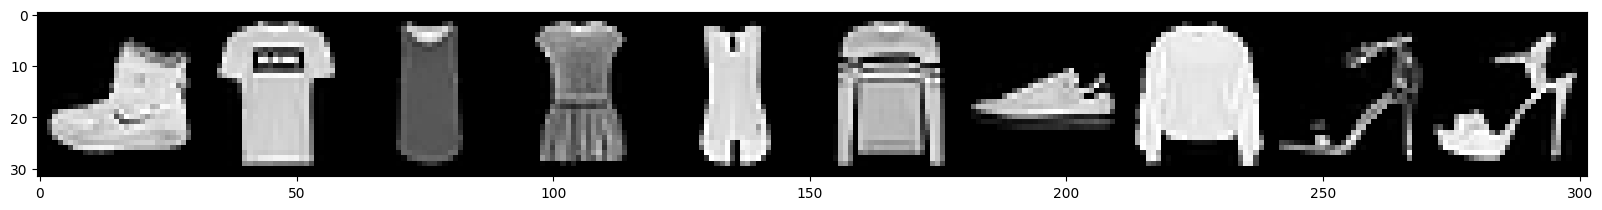

In [3]:
x = [train_dataset[i][0] for i in range(10)]
labels = [idx_to_class[train_dataset[i][1]] for i in range(10)]
print(labels)

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(x, nrow=10))
plt.show()

### 1.1 Define a Neural Network

In [4]:
# Setting up a batch size hyperparameter
BATCH_SIZE = 32

# Turning datasets into iterables
train_dataloader = DataLoader(dataset = train_dataset,
                        batch_size = BATCH_SIZE,
                        shuffle = True)

test_dataloader = DataLoader(dataset = test_dataset,
                       batch_size = BATCH_SIZE,
                       shuffle = False)

# Getting list of all class labels
class_labels = train_dataset.classes

# Device agnostic code
device = 'mps' if torch.has_mps else 'gpu' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')


Device: mps


In [5]:
next(iter(train_dataloader))

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
           [0.0000

In [6]:
### Defining train and test loop functions
def train(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    
    av_train_loss = 0

    # Put model to device and into training mode
    model.to(device)
    model.train()
    
    for batch, (X, y) in enumerate(data_loader):
        
        # Put data on the target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass (raw logit output)
        output = model(X)
        
        # 2. Calculate loss and accuracy per batch
        loss = loss_fn(output, y)
        av_train_loss += loss
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Backpropagation
        loss.backward()
        
        # 5. Gradrient descent
        optimizer.step()
        
        if batch % 250 == 0.0:
            print(f'Looked at {batch*32}/60000 images.')
    
    av_train_loss /= len(data_loader)
    print(f'\nTrain loss: {av_train_loss:.5f}')
    

def test(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
    
    preds = []
    av_test_loss = 0
    
    # Put model to device and into testing mode
    model.to(device)
    model.eval()
    
    # Turn on inference mode context manager
    with torch.inference_mode():
        
        for X, y in data_loader:
            
            # Put data on the target device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            output = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss = loss_fn(output, y)
            av_test_loss += test_loss
            
            # 3. Save predictions
            pred = torch.softmax(output.squeeze(), dim = 0).argmax(dim = 1)
            preds.append(pred.cpu())
        
        av_test_loss /= len(data_loader)
        print(f'\nTest loss: {av_test_loss:.5f}')
    
    # return predictions as tensor
    return torch.cat(preds)


In [7]:
# Define model class
class ClassificationNN(nn.Module):
   
    '''
    TinyVGG model architecture.
    '''
    
    def __init__(self, input_shape: int, hidden_units: int, output_shape:int):
        
        super().__init__()
        
        # Block 1 (Convolution)
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        # Block 2 (Convolution)
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        # Block 3 (Classifier)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units*7*7,
                      out_features = output_shape)
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        
        return x
        

In [8]:
# Creating an instance of ClassificationNN()
cnn_model = ClassificationNN(input_shape = 1, # black & white -> 1 color channel
                             hidden_units = 10, # TinyVGG model architecture
                             output_shape = len(class_labels)).to(device) # 1 output for each possible class label
                             

### 1.2 Define optimization procedure on FashionMNIST

In [9]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(params = cnn_model.parameters(),
                            lr = 0.1)


### 1.3 Train classifier on training set

In [16]:
# Define train epochs
EPOCHS = 5

# Setting timer to track computation time
time_start = timer()

for epoch in tqdm(range(EPOCHS)):
    print(f'\nEpoch: {epoch+1}\n-------')
    
    ### Training
    train(model = cnn_model, data_loader = train_dataloader, loss_fn = loss_fn, optimizer = optimizer, device = device)
    
    ### Testing
    test(model = cnn_model, data_loader = test_dataloader, loss_fn = loss_fn, device = device)
    
# Computation time
time_end = timer()
print(f'\n\n Total traing time for {EPOCHS} epochs on {device}: {(time_end - time_start):.4f} seconds')
    

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 1
-------
Looked at 0/60000 images.
Looked at 8000/60000 images.
Looked at 16000/60000 images.
Looked at 24000/60000 images.
Looked at 32000/60000 images.
Looked at 40000/60000 images.
Looked at 48000/60000 images.
Looked at 56000/60000 images.

Train loss: 0.58339

Test loss: 0.38823

Epoch: 2
-------
Looked at 0/60000 images.
Looked at 8000/60000 images.
Looked at 16000/60000 images.
Looked at 24000/60000 images.
Looked at 32000/60000 images.
Looked at 40000/60000 images.
Looked at 48000/60000 images.
Looked at 56000/60000 images.

Train loss: 0.34389

Test loss: 0.32844

Epoch: 3
-------
Looked at 0/60000 images.
Looked at 8000/60000 images.
Looked at 16000/60000 images.
Looked at 24000/60000 images.
Looked at 32000/60000 images.
Looked at 40000/60000 images.
Looked at 48000/60000 images.
Looked at 56000/60000 images.

Train loss: 0.30751

Test loss: 0.31814

Epoch: 4
-------
Looked at 0/60000 images.
Looked at 8000/60000 images.
Looked at 16000/60000 images.
Looked at 24000

In [17]:
### Saving the model
from pathlib import Path

# 1. Create model's directory
MODEL_PATH = Path('AIA_HW4_models')
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. Create model save path
MODEL_NAME = 'AIA_cnn_model'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Saving model's state_dict()
torch.save(obj = cnn_model.state_dict(), f = MODEL_SAVE_PATH)

print(MODEL_SAVE_PATH)

AIA_HW4_models/AIA_cnn_model


In [10]:
### Loading the model

# 1. Creating instance of ClassificationNN() class
loaded_cnn_model = ClassificationNN(input_shape = 1, hidden_units = 10, output_shape = 10)

# 2. Load saved state_dict() into model
loaded_cnn_model.load_state_dict(torch.load('AIA_HW4_models/AIA_cnn_model'))

# 3. Loaded model to device
loaded_cnn_model.to(device)

ClassificationNN(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### 1.4 Evaluate model on test set

In [11]:
# Get predictions with test method
predictions = test(model = loaded_cnn_model, data_loader = test_dataloader, loss_fn = loss_fn, device = device)



Test loss: 0.30700


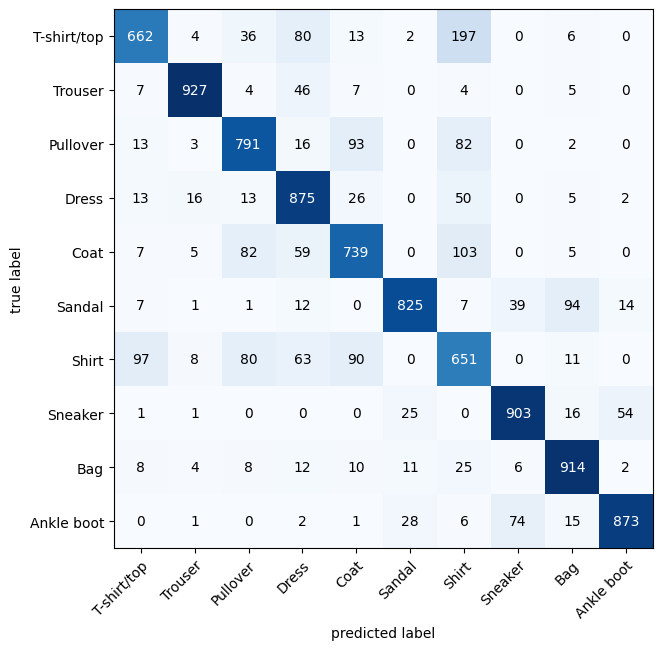

In [12]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion instance and compare predictions to targets
CM = ConfusionMatrix(task = 'multiclass', num_classes = len(class_labels))
CM_tr = CM(preds = predictions,
          target = test_dataset.targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = CM_tr.numpy(),
    class_names = class_labels,
    figsize = (10, 7))
    

#### 1.4.2 Compute Accuracy, Precision, Recall and F1 using the maximum response

In [13]:
# TP, FP, FN for each class:
TP_tr = torch.stack([CM_tr[i,i] for i in range(len(class_labels))])
FP_tr = torch.stack([CM_tr[:i,i].sum() + CM_tr[i+1:,i].sum() for i in range(len(class_labels))])
FN_tr = torch.stack([CM_tr[i].sum() - CM_tr[i,i] for i in range(len(class_labels))])
TN_tr = torch.stack([CM_tr.sum() - TP_tr[i] - FP_tr[i] - FN_tr[i] for i in range(len(class_labels))])

# Accuracy
acc_tr = (TP_tr + TN_tr) / CM_tr.sum()

# Precision
pre_tr = TP_tr/(TP_tr + FP_tr)

# Recall
rec_tr = TP_tr/(TP_tr + FN_tr)

# F1 Score
f1s_tr = 2 * pre_tr * rec_tr / (pre_tr + rec_tr)


In [14]:
# Visualization in dataframe
import pandas as pd
columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
eval_metrics_mat = torch.cat((acc_tr.unsqueeze(0), pre_tr.unsqueeze(0), rec_tr.unsqueeze(0), f1s_tr.unsqueeze(0))).T
px = pd.DataFrame(data = eval_metrics_mat, index = class_labels, columns = columns).astype('float')
px

,Accuracy,Precision,Recall,F1 Score
T-shirt/top,0.9509,0.812270,0.662,0.729477
Trouser,0.9884,0.955670,0.927,0.941117
Pullover,0.9567,0.779310,0.791,0.785112
Dress,0.9585,0.751073,0.875,0.808314
Coat,0.9499,0.754852,0.739,0.746842
Sandal,0.9759,0.925926,0.825,0.872554
Shirt,0.9177,0.578667,0.651,0.612706
Sneaker,0.9784,0.883562,0.903,0.893175
Bag,0.9755,0.851817,0.914,0.881814
Ankle boot,0.9801,0.923810,0.873,0.897686


#### 1.4.3 Visualize Precision-Recall curve for different classes 

torch.Size([10000, 1, 28, 28])


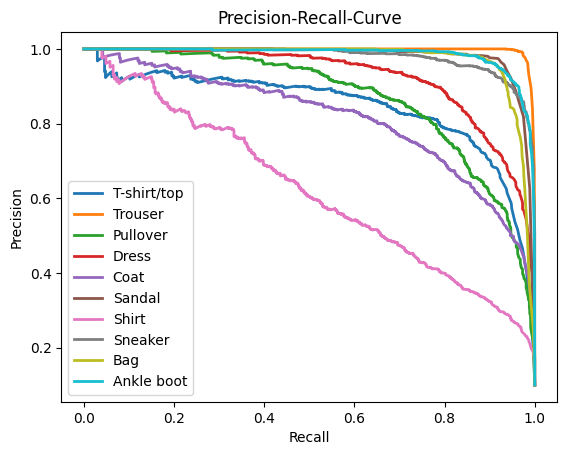

In [15]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve

# Binarize target labels
targets = label_binarize(test_dataset.targets, classes = [*range(len(class_labels))])

# Dataloader with all data in one batch
test_dataloader_all = DataLoader(test_dataset, batch_size = len(test_dataset))

print(next(iter(test_dataloader_all))[0].shape)

# Get predictions on dataloader
y_logits = loaded_cnn_model(next(iter(test_dataloader_all))[0].to(device))
y_pred_probs = torch.softmax(y_logits, dim = 0)
y_pred_probs = y_pred_probs.cpu().detach().numpy()
y_pred_probs = np.exp(y_pred_probs)

# Plotting the precision-recall curve
for i in range(len(class_labels)):
    precision, recall, _ = precision_recall_curve(y_true = targets[:, i],
                                                        probas_pred = y_pred_probs[:, i])
    plt.plot(recall, precision, lw = 2, label = class_labels[i])
    
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision-Recall-Curve")
plt.show()


#### 1.4.4 Visualize example images with predicted classes

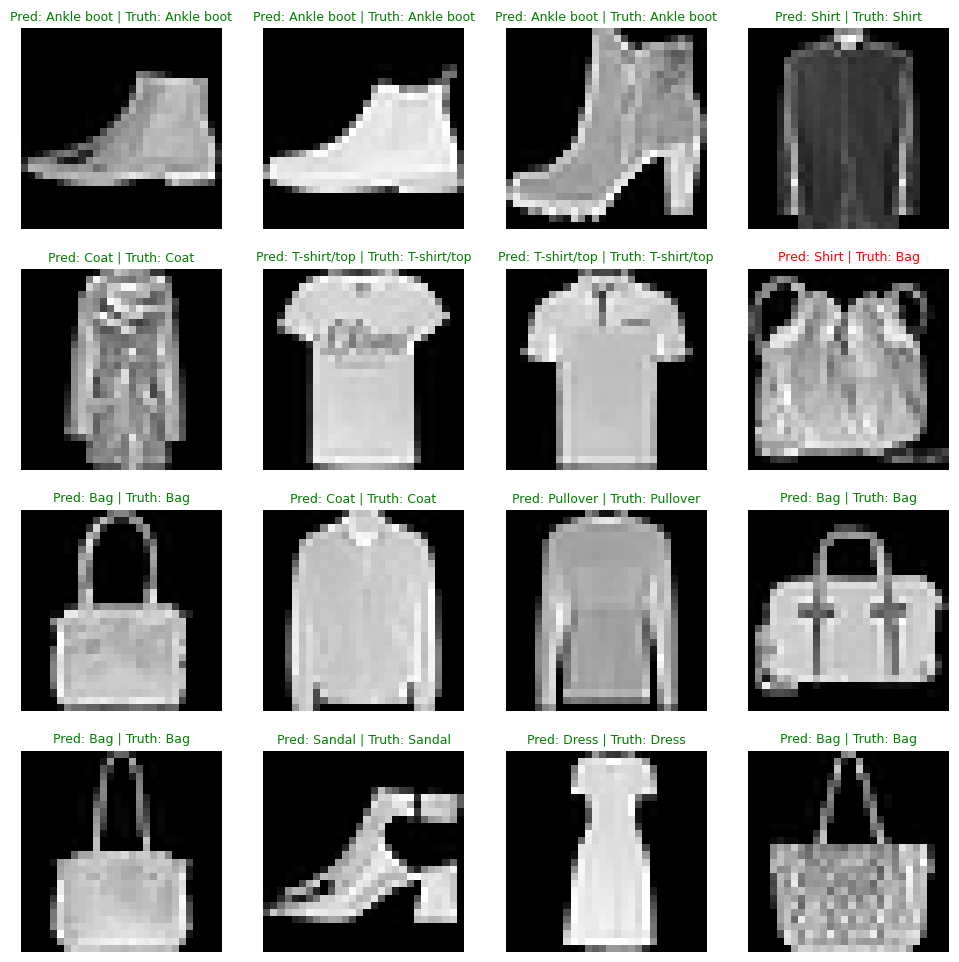

In [16]:
# Drawing random samples
import random

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_dataset), k = 16): # 16 random samples
    test_samples.append(sample)
    test_labels.append(label)

# Making predictions
pred_probs = [] # create empty list of prediction probabilities
cnn_model.eval()
with torch.inference_mode():
    for sample in test_samples:
                
        # prediction with model (raw logits)
        y_logit = loaded_cnn_model(sample.unsqueeze(dim = 0).to(device))
        
        # logits -> prediction probabilities
        pred_prob = torch.softmax(y_logit.squeeze(), dim = 0)
        
        # prediction probability to list (and to cpu for further computation)
        pred_probs.append(pred_prob.cpu())

# list -> tensor
pred_probs_tensor = torch.stack(pred_probs)

# prediction probabilities -> label
pred_labels = pred_probs_tensor.argmax(dim = 1)
       

# Plot images of the samples
plt.figure(figsize = (12, 12))
rows = 4
cols = 4
for i in range(len(test_labels)):
    
    # Create subplot
    plt.subplot(rows, cols, i+1)
    
    # Plot sample image
    plt.imshow(test_samples[i].squeeze(), cmap = 'gray')
    
    # Prediction label (text)
    pred_label = class_labels[pred_labels[i]]
    
    # Truth label (text)
    truth_label = class_labels[test_labels[i]]
    
    # Different colored title for good/bad classification
    title_text = f'Pred: {pred_label} | Truth: {truth_label}'
    if pred_label == truth_label:
        plt.title(title_text, fontsize = 9, c = 'g') # green text if classified correctly
    else:
        plt.title(title_text, fontsize = 9, c = 'r') # red text if classified incorrectly
    
    plt.axis(False)

# Task 2: Image Denoising
1. define a Neural Network
2. define optimization procedure on NoisyFashionMNIST
3. train denoising model
4. Evaluate model

## Dataset
Random augmentations are added to the original dataset.

In [17]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from utils import NoisyFashionMNIST

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [18]:
train_dataset = NoisyFashionMNIST("./data", True)
test_dataset = NoisyFashionMNIST("./data", False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


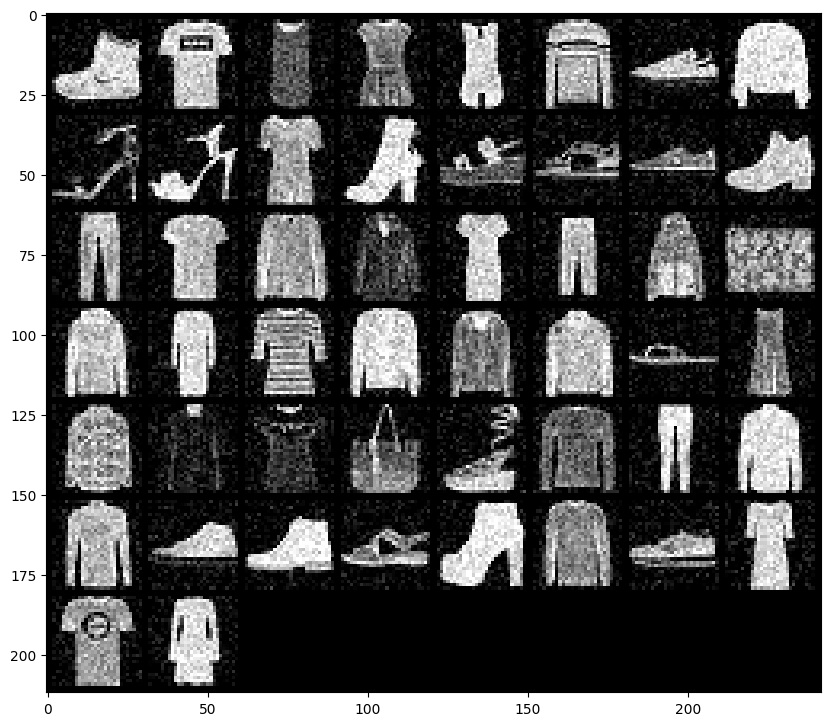

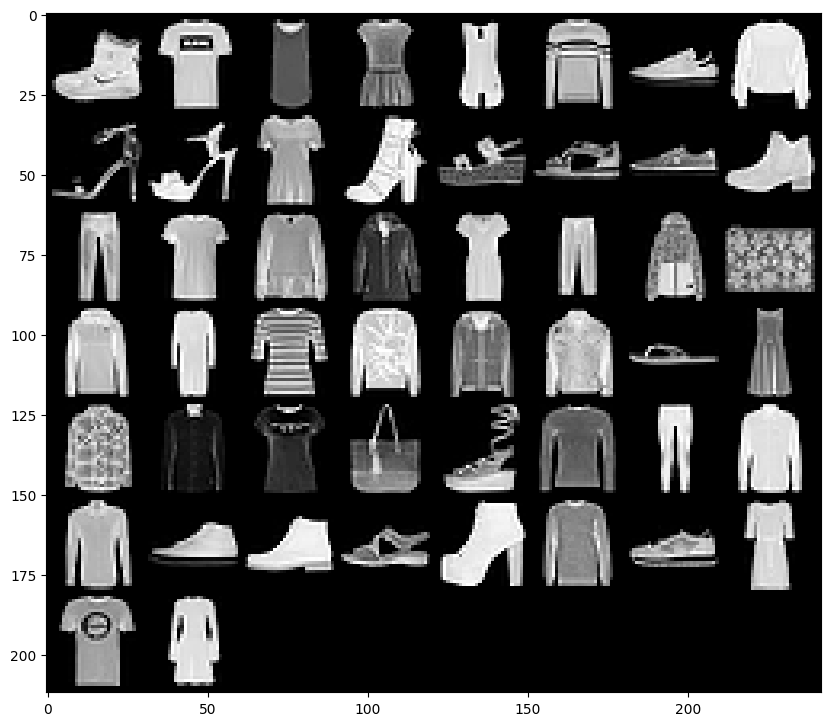

In [19]:
x = [train_dataset[i][0] for i in range(50)]
y = [train_dataset[i][1] for i in range(50)]

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(x))
plt.show()

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(y))
plt.show()

### 2.1 Define a Neural Network

In [20]:
### Preparations
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from timeit import default_timer as timer

# Setting up a batch size hyperparameter
BATCH_SIZE = 32

# Turning datasets into iterables
train_dataloader = DataLoader(dataset = train_dataset,
                        batch_size = BATCH_SIZE,
                        shuffle = True)

test_dataloader = DataLoader(dataset = test_dataset,
                       batch_size = BATCH_SIZE,
                       shuffle = False)

# Getting list of all class labels
#class_labels = train_dataset.classes

# Device agnostic code
device = 'mps' if torch.has_mps else 'gpu' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')


Device: mps


In [21]:
### Defining train and test loop functions
def train(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    
    av_train_loss = 0

    # Put model to device and into training mode
    model.to(device)
    model.train()
    
    for batch, (X, y) in enumerate(data_loader):
        
        # Put data on the target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass (raw logit output)
        output = model(X)
        
        # 2. Calculate loss and accuracy per batch
        loss = loss_fn(output, y)
        av_train_loss += loss
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Backpropagation
        loss.backward()
        
        # 5. Gradrient descent
        optimizer.step()
        
        if batch % 250 == 0.0:
            print(f'Looked at {batch*32}/60000 images.')
    
    av_train_loss /= len(data_loader)
    print(f'\nTrain loss: {av_train_loss:.5f}')
    

def test(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
    
    preds = []
    av_test_loss = 0
    
    # Put model to device and into testing mode
    model.to(device)
    model.eval()
    
    # Turn on inference mode context manager
    with torch.inference_mode():
        
        for X, y in data_loader:
            
            # Put data on the target device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            output = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss = loss_fn(output, y)
            av_test_loss += test_loss
            
            # 3. Save predictions
            pred = torch.softmax(output.squeeze(), dim = 0).argmax(dim = 1)
            preds.append(pred.cpu())
        
        av_test_loss /= len(data_loader)
        print(f'\nTest loss: {av_test_loss:.5f}')
    
    # return predictions as tensor
    return torch.cat(preds)

In [22]:
class DenoisingNN(nn.Module):
    '''
    Autoencoder.
    '''
    
    def __init__(self,color_channels ,encoded_space_dim):
        
        super().__init__()
        
        ### Encoder block
        
        ## Convolutional block
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(in_channels = color_channels,
                      out_channels = 8,
                      kernel_size = 3,
                      stride = 2,
                      padding = 1,),
            nn.ReLU(True),
            nn.Conv2d(in_channels = 8,
                      out_channels = 16,
                      kernel_size = 3,
                      stride = 2,
                      padding = 1,),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(in_channels = 16,
                      out_channels = 32,
                      kernel_size = 3,
                      stride = 2,
                      padding = 0,),
            nn.ReLU(True),
        )
        
        ## Flatten layer
        self.flatten = nn.Flatten(start_dim = 1)
        
        ## Linear block
        self.encoder_lin = nn.Sequential(
            nn.Linear(in_features = 3 * 3 * 32,
                      out_features = 128),
            nn.ReLU(True),
            nn.Linear(in_features = 128, 
                      out_features = encoded_space_dim)
        )
        
        ### Decoder block
        
        ## Linear block
        self.decoder_lin = nn.Sequential(
            nn.Linear(in_features = encoded_space_dim,
                      out_features = 128),
            nn.ReLU(True),
            nn.Linear(in_features = 128,
                      out_features = 3 * 3 *32),
            nn.ReLU(True)
        )
        
        ## Unflatten layer
        self.unflatten = nn.Unflatten(dim = 1,
                                      unflattened_size = (32, 3, 3))
        
        ## Convolutional block
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 32,
                               out_channels = 16,
                               kernel_size = 3,
                               stride = 2,
                               output_padding = 0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels = 16,
                               out_channels = 8,
                               kernel_size = 3,
                               stride = 2,
                               padding = 1,
                               output_padding = 1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels = 8,
                               out_channels = color_channels,
                               kernel_size = 3,
                               stride = 2,
                               padding = 1,
                               output_padding = 1)
        )
    
    def forward(self, x):
        
        # Encoding
        x = self.encoder_conv(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        
        # Decoding
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        
        # Activation
        x = torch.sigmoid(x)
        
        return x


In [23]:
# Creating an instance of DenoisingNN()
denoise_model = DenoisingNN(color_channels = 1, encoded_space_dim = 4).to(device)


### 2.2 Define optimization procedure on NoisyFashionMNIST

In [24]:
# Loss function
loss_fn = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(params = denoise_model.parameters(),
                            lr = 0.1)


### 2.3 Train denoising model

In [25]:
# Define train epochs
EPOCHS = 5

# Setting timer to track computation time
time_start = timer()

for epoch in tqdm(range(EPOCHS)):
    print(f'\nEpoch: {epoch+1}\n-------')
    
    ### Training
    train(model = denoise_model, data_loader = train_dataloader, loss_fn = loss_fn, optimizer = optimizer, device = device)
    
    ### Testing
    test(model = denoise_model, data_loader = test_dataloader, loss_fn = loss_fn, device = device)
    
# Computation time
time_end = timer()
print(f'\n\n Total traing time for {EPOCHS} epochs on {device}: {(time_end - time_start):.4f} seconds')
            

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 1
-------
Looked at 0/60000 images.
Looked at 8000/60000 images.
Looked at 16000/60000 images.
Looked at 24000/60000 images.
Looked at 32000/60000 images.
Looked at 40000/60000 images.
Looked at 48000/60000 images.
Looked at 56000/60000 images.

Train loss: 0.03397

Test loss: 0.02649

Epoch: 2
-------
Looked at 0/60000 images.
Looked at 8000/60000 images.
Looked at 16000/60000 images.
Looked at 24000/60000 images.
Looked at 32000/60000 images.
Looked at 40000/60000 images.
Looked at 48000/60000 images.
Looked at 56000/60000 images.

Train loss: 0.02597

Test loss: 0.02867

Epoch: 3
-------
Looked at 0/60000 images.
Looked at 8000/60000 images.
Looked at 16000/60000 images.
Looked at 24000/60000 images.
Looked at 32000/60000 images.
Looked at 40000/60000 images.
Looked at 48000/60000 images.
Looked at 56000/60000 images.

Train loss: 0.02481

Test loss: 0.02531

Epoch: 4
-------
Looked at 0/60000 images.
Looked at 8000/60000 images.
Looked at 16000/60000 images.
Looked at 24000

In [26]:
### Saving the model
from pathlib import Path

# 1. Create model's directory
MODEL_PATH = Path('AIA_HW4_models')
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. Create model save path
MODEL_NAME = 'AIA_denoise_model'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Saving model's state_dict()
torch.save(obj = denoise_model.state_dict(), f = MODEL_SAVE_PATH)

print(MODEL_SAVE_PATH)

AIA_HW4_models/AIA_denoise_model


In [27]:
### Loading the model

# 1. Creating instance of ClassificationNN() class
loaded_denoise_model = DenoisingNN(color_channels = 1, encoded_space_dim = 4)

# 2. Load saved state_dict() into model
loaded_denoise_model.load_state_dict(torch.load('AIA_HW4_models/AIA_denoise_model'))

# 3. Loaded model to device
loaded_denoise_model.to(device)

DenoisingNN(
  (encoder_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_siz

### 2.4 Evaluate model

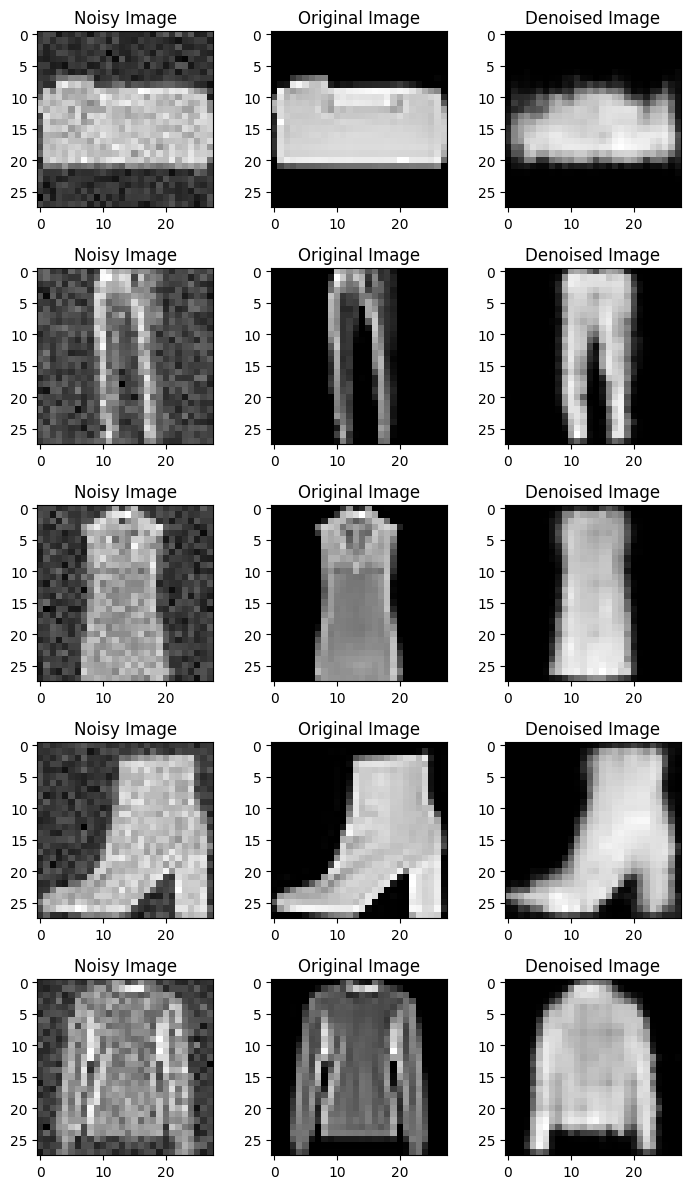

In [28]:
# Drawing random samples
import random

SAMPLES = 5
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_dataset), k = SAMPLES): # 16 random samples
    test_samples.append(sample)
    test_labels.append(label)

fig = plt.figure(figsize = (12, 12))
rows = SAMPLES

for i in range(SAMPLES):
    
    data = test_samples[i]
    target = test_labels[i]
    
    denoised_data = loaded_denoise_model(data[:, None].to(device))
    
    # Plot noisy image
    ax = plt.subplot(SAMPLES, rows, rows * i +1)
    plt.tight_layout()
    ax.set_title("Noisy Image")
    plt.imshow(data[0], cmap = 'gray', interpolation = 'none')
    
    # Plot original image
    ax = plt.subplot(SAMPLES, rows ,rows * i + 2) 
    ax.set_title("Original Image")
    plt.imshow(target[0], cmap = 'gray', interpolation = 'none')
    
    # Plot denoised image
    ax = plt.subplot(SAMPLES, rows, rows * i + 3) 
    ax.set_title("Denoised Image")
    plt.imshow(denoised_data.cpu().detach().numpy()[0][0], cmap = 'gray', interpolation = 'none')
